In [1]:
from __future__ import print_function ## Force python3-like printing

try:
    from importlib import reload
except:
    pass

%matplotlib inline
# %matplotlib notebook
from matplotlib import pyplot as plt

import os
import warnings

import numpy as np
from astropy.table import Table

import pycoco as pcc

reload(pcc) ## FOR DEV
reload(pcc.kcorr) ## FOR DEV
reload(pcc.functions) ## FOR DEV
reload(pcc.classes) ## FOR DEV
reload(pcc.colours)

warnings.resetwarnings() ## FOR DEV

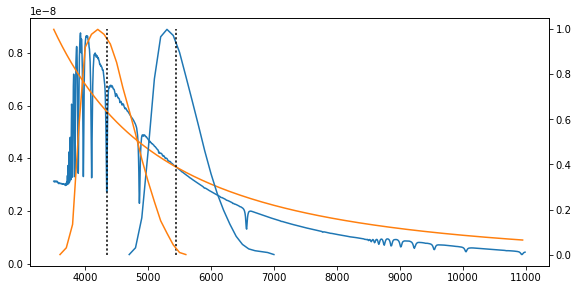

In [2]:
V = pcc.load_filter('/Users/berto/Code/CoCo/data/filters/BessellV.dat')
B = pcc.load_filter('/Users/berto/Code/CoCo/data/filters/BessellB.dat')

vega = pcc.kcorr.load_vega()
AB = pcc.kcorr.load_AB()

fig = plt.figure(figsize=[8, 4])
fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                    right = 0.99, hspace=0, wspace = 0)

ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(vega.wavelength, vega.flux)
ax1.plot(AB.wavelength, AB.flux)

ax2.plot(V.wavelength, V.throughput)
ax2.plot([V.lambda_effective.value, V.lambda_effective.value], [0,1], color = pcc.colours.hex["black"], ls = ":")
ax2.plot(B.wavelength, B.throughput)
ax2.plot([B.lambda_effective.value, B.lambda_effective.value], [0,1], color = pcc.colours.hex["black"], ls = ":")

In [3]:
print(pcc.kcorr.calc_offset_AB_minus_Vega("BessellV"))
print(pcc.kcorr.calc_offset_AB_minus_Vega("BessellB"))
print(pcc.kcorr.calc_AB_flux("BessellB"))
print(pcc.kcorr.calc_vega_flux("BessellB"))
pcc.kcorr.calc_vega_zp("BessellB")
# kcorr.calc_vega_mag("BessellV")
pcc.kcorr.calc_vega_mag("BessellB")

0.0247907219878
0.13835977858
5.46590534646e-06
6.03956998519e-06


-0.65121903565065864

In [4]:
# inpath = "/Users/berto/data/CoreCollapse/phot/rf/SN2009jf/final/SN2009jf.dat"
# phot = pcc.load(inpath)

In [5]:
sn = pcc.SNClass("SN2006aj")
sn.load_phot( path = '/Users/berto/Code/CoCo/data/lc/SN2006aj.dat')
sn.load_list("/Users/berto/Code/CoCo/lists/SN2006aj.list")
# sn.load_spec()
# sn.check_overlaps()
# sn.get_lcfit("/Users/berto/Code/CoCo/recon/SN2006aj.dat")

/Users/berto/Code/CoCo/data/lc/SN2006aj.dat


In [6]:
sn.phot.load("/Users/berto/Code/CoCo/data/lc/SN2006aj.dat")

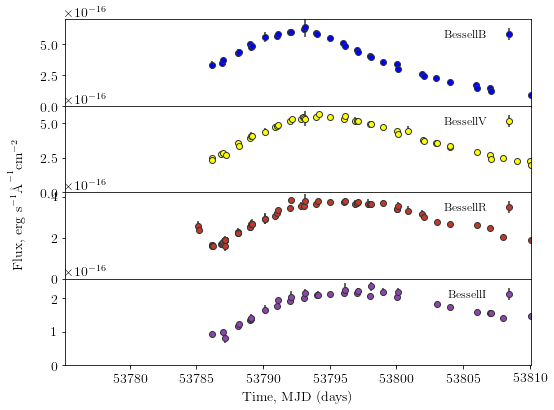

In [7]:
sn.plot_lc()